In [ ]:
!pip install gtsam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 37.4 MB/s eta 0:00:00


In [ ]:
import gtsam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [ ]:
def read_g2o_3d(filename):

  data_3d = pd.read_csv(filename, delimiter = ' ', names = list('abcdefghijklmnopqrstuvwxyzABCDE'))
  data_3d.to_csv("data_3d.csv", index=None)

  df = pd.read_csv("data_3d.csv")

  vertices_no = 0
  edges_no = 0

  for i in range(df.shape[0]):

    if df.loc[i][0] == "VERTEX_SE3:QUAT":
      vertices_no+=1
    elif df.loc[i][0] == "EDGE_SE3:QUAT":
      edges_no+=1

  vertices_store = np.zeros((vertices_no,9))
  edges_store = np.zeros((edges_no,30))

  for j in range(vertices_no):

    vertices_store[j,:] = df.loc[j][1:10]

  for k in range(edges_no):

    edges_store[k,:] = df.loc[vertices_no+k][1:31]

  return vertices_store, edges_store

vertices_store_3d, edges_store_3d = read_g2o_3d("parking-garage.g2o")

In [ ]:
def construct_info_3d(info_vector_3d):

    q11 = info_vector_3d[0]
    q12 = info_vector_3d[1]
    q13 = info_vector_3d[2]
    q14 = info_vector_3d[3]
    q15 = info_vector_3d[4]
    q16 = info_vector_3d[5]
    q22 = info_vector_3d[6]
    q23 = info_vector_3d[7]
    q24 = info_vector_3d[8]
    q25 = info_vector_3d[9]
    q26 = info_vector_3d[10]
    q33 = info_vector_3d[11]
    q34 = info_vector_3d[12]
    q35 = info_vector_3d[13]
    q36 = info_vector_3d[14]
    q44 = info_vector_3d[15]
    q45 = info_vector_3d[16]
    q46 = info_vector_3d[17]
    q55 = info_vector_3d[18]
    q56 = info_vector_3d[19]
    q66 = info_vector_3d[20]
    # q1 = info_vector_3d[:6]
    # q2 = np.hstack((info_vector_3d[1],info_vector_3d[6:11]))
    # q3 = np.hstack((np.array([info_vector_3d[2],info_vector_3d[7]]),info_vector_3d[11:15]))
    # q4 = np.hstack((np.array([info_vector_3d[3],info_vector_3d[8],info_vector_3d[12]]),info_vector_3d[15:18]))
    # q5 = np.hstack((np.array([info_vector_3d[4],info_vector_3d[9],info_vector_3d[13], info_vector_3d[16]]),info_vector_3d[18:20]))
    # q6 = np.hstack((np.array([info_vector_3d[5],info_vector_3d[10],info_vector_3d[14], info_vector_3d[17],info_vector_3d[19]]),info_vector_3d[20]))
    # info_matrix = np.vstack((q1,q2,q3,q4,q5,q6))

    info_matrix = np.array([[q11,q12,q13,q14,q15,q16],[q12,q22,q23,q24,q25,q26],[q13,q23,q33,q34,q35,q36],[q14,q24,q34,q44,q45,q46],[q15,q25,q35,q45,q55,q56],[q16,q26,q36,q46,q56,q66]])

    return info_matrix

graph3d = gtsam.NonlinearFactorGraph()

priorMean = gtsam.Pose3(gtsam.Rot3.Quaternion(1,0,0,0), gtsam.Point3(0,0,0))

priorNoise = gtsam.noiseModel.Gaussian.Information(construct_info_3d(edges_store_3d[0,9:]))
graph3d.add(gtsam.PriorFactorPose3(0, priorMean, priorNoise))

for i in range(edges_store_3d.shape[0]):

  info_vector = edges_store_3d[i,9:]
  odometryNoise = gtsam.noiseModel.Gaussian.Information(construct_info_3d(info_vector))
  graph3d.add(gtsam.BetweenFactorPose3(int(edges_store_3d[i,0]), int(edges_store_3d[i,1]), gtsam.Pose3(gtsam.Rot3.Quaternion(edges_store_3d[i,8], edges_store_3d[i,5],edges_store_3d[i,6],edges_store_3d[i,7]), gtsam.Point3(edges_store_3d[i,2],edges_store_3d[i,3],edges_store_3d[i,4])), odometryNoise))

initialEstimate3d = gtsam.Values()

for j in range(vertices_store_3d.shape[0]):

  pose_est_3d = gtsam.Pose3(gtsam.Rot3.Quaternion(vertices_store_3d[j,7],vertices_store_3d[j,4],vertices_store_3d[j,5],vertices_store_3d[j,6]), gtsam.Point3(vertices_store_3d[j,1],vertices_store_3d[j,2],vertices_store_3d[j,3]))
  initialEstimate3d.insert(int(vertices_store_3d[j,0]), pose_est_3d)

# print(initialEstimate3d)

optimizer3d = gtsam.GaussNewtonOptimizer(graph3d, initialEstimate3d)
result3d = optimizer3d.optimizeSafely()

# print(result3d)

optimized_store_3d = np.zeros((vertices_store_3d.shape[0],3))

for k in range(vertices_store_3d.shape[0]):

  optimized_store_3d[k,:] = [result3d.atPose3(k).x(),result3d.atPose3(k).y(),result3d.atPose3(k).z()]

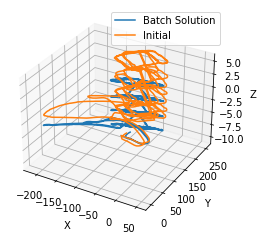

In [ ]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot(optimized_store_3d[:,0],optimized_store_3d[:,1],optimized_store_3d[:,2],label="Batch Solution")
ax.plot(vertices_store_3d[:,1],vertices_store_3d[:,2],vertices_store_3d[:,3],label="Initial")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

In [ ]:
def incremental_solution_3d(poses, edges):

  isam = gtsam.ISAM2()
  result = None

  def construct_info_3d(info_vector_3d):

      q11 = info_vector_3d[0]
      q12 = info_vector_3d[1]
      q13 = info_vector_3d[2]
      q14 = info_vector_3d[3]
      q15 = info_vector_3d[4]
      q16 = info_vector_3d[5]
      q22 = info_vector_3d[6]
      q23 = info_vector_3d[7]
      q24 = info_vector_3d[8]
      q25 = info_vector_3d[9]
      q26 = info_vector_3d[10]
      q33 = info_vector_3d[11]
      q34 = info_vector_3d[12]
      q35 = info_vector_3d[13]
      q36 = info_vector_3d[14]
      q44 = info_vector_3d[15]
      q45 = info_vector_3d[16]
      q46 = info_vector_3d[17]
      q55 = info_vector_3d[18]
      q56 = info_vector_3d[19]
      q66 = info_vector_3d[20]

      info_matrix = np.array([[q11,q12,q13,q14,q15,q16],[q12,q22,q23,q24,q25,q26],[q13,q23,q33,q34,q35,q36],[q14,q24,q34,q44,q45,q46],[q15,q25,q35,q45,q55,q56],[q16,q26,q36,q46,q56,q66]])

      return info_matrix

  for i in range(poses.shape[0]):

    graph = gtsam.NonlinearFactorGraph()
    initialEstimate = gtsam.Values()

    if poses[i,0] == 0:

      priorMean = gtsam.Pose3(gtsam.Rot3.Quaternion(1,0,0,0), gtsam.Point3(0,0,0))
      priorNoise = gtsam.noiseModel.Gaussian.Information(construct_info_3d(edges_store_3d[0,9:]))
      graph.add(gtsam.PriorFactorPose3(0, priorMean, priorNoise))

      initialEstimate.insert(int(poses[i,0]), priorMean)

    else:

      prevPose = result.atPose3(i-1)
      initialEstimate.insert(int(poses[i,0]), prevPose)

      for j in range(edges.shape[0]):

        if edges[j,1] == poses[i,0]:

          info = construct_info_3d(edges[j,9:])
          odometryNoise = gtsam.noiseModel.Gaussian.Information(info)
          graph.add(gtsam.BetweenFactorPose3(int(edges[j,0]), int(edges[j,1]), gtsam.Pose3(gtsam.Rot3.Quaternion(edges[j,8], edges[j,5],edges[j,6],edges[j,7]), gtsam.Point3(edges[j,2],edges[j,3],edges[j,4])), odometryNoise))

    isam.update(graph, initialEstimate)
    result = isam.calculateEstimate()

  return result

result_incremental = incremental_solution_3d(vertices_store_3d, edges_store_3d)

incremental_store_3d = np.zeros((vertices_store_3d.shape[0],3))

for k in range(vertices_store_3d.shape[0]):

  incremental_store_3d[k,:] = [result_incremental.atPose3(k).x(),result_incremental.atPose3(k).y(),result_incremental.atPose3(k).z()]

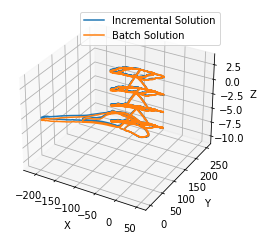

In [ ]:
# fig = plt.figure()
# ax = plt.axes(projection="3d")
# ax.plot(incremental_store_3d[:,0],incremental_store_3d[:,1],incremental_store_3d[:,2])
# # ax.plot(vertices_store_3d[:,1],vertices_store_3d[:,2],vertices_store_3d[:,3])
# ax.plot(optimized_store_3d[:,0],optimized_store_3d[:,1],optimized_store_3d[:,2])
# plt.show()

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot(incremental_store_3d[:,0],incremental_store_3d[:,1],incremental_store_3d[:,2],label="Incremental Solution")
ax.plot(optimized_store_3d[:,0],optimized_store_3d[:,1],optimized_store_3d[:,2],label="Batch Solution")
# ax.plot(vertices_store_3d[:,1],vertices_store_3d[:,2],vertices_store_3d[:,3],label="Initial")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()